# 角速度(z成分)から肩屈曲角を得る方法(数値積分)

## １．前準備

◼️必要モジュールのインポート：

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lpf

> `lpf`はローパスフィルタモジュール。`lpf.py`をデータおよびJupyterノートブックと同じフォルダに入れておくこと。

◼️センサデータの読み込み。読み込んだデータをデータフレーム変数`df`に格納：

In [3]:
df = pd.read_csv("memdata_TSND121-13121423_2019-05-21.csv", header=None,
                 names=['item', 't', 'acc_x', 'acc_y', 'acc_z', 'omega_x', 'omega_y', 'omega_z'])

> `"memdata_TSND121-13121423_2019-05-21.csv"`を自分のグループのデータCSVファイルに置き換えること。

◼️データフレーム`df`の確認：

In [4]:
df.head()

,item,t,acc_x,acc_y,acc_z,omega_x,omega_y,omega_z
0,ags,51000000,2508,10181,1854,557,1804,-1670
1,ags,51000001,2508,10162,1910,538,1780,-1651
2,ags,51000002,2417,10164,1839,532,1773,-1639
3,ags,51000003,2386,10142,1891,514,1755,-1615
4,ags,51000004,2376,10110,1871,490,1737,-1590


In [5]:
df.tail()

,item,t,acc_x,acc_y,acc_z,omega_x,omega_y,omega_z
68125,ags,51068125,4280,8555,2874,51,212,158
68126,ags,51068126,4383,8563,2894,45,206,140
68127,ags,51068127,4319,8570,2806,39,200,122
68128,ags,51068128,4361,8541,2850,27,200,128
68129,ags,51068129,4395,8509,2826,27,225,159


◼️データの要約統計量の確認：

In [4]:
df.describe()

,t,acc_x,acc_y,acc_z,omega_x,omega_y,omega_z
count,6.813000e+04,68130.000000,68130.000000,68130.000000,68130.000000,68130.000000,68130.000000
mean,5.103406e+07,4208.410230,3896.143711,1893.761617,584.288654,-395.946499,-230.229458
std,1.966758e+04,5395.814869,8896.314606,2357.702830,4479.194616,2450.534206,16971.549933
min,5.100000e+07,-8055.000000,-10064.000000,-3384.000000,-8058.000000,-10902.000000,-36670.000000
25%,5.101703e+07,-743.000000,-5770.000000,-69.000000,-2796.000000,-1945.000000,-15022.000000
50%,5.103406e+07,5022.000000,7723.000000,2174.000000,-83.000000,-366.000000,-92.000000
75%,5.105110e+07,8858.000000,10850.000000,3607.000000,3874.000000,1048.000000,13555.000000
max,5.106813e+07,15137.000000,21202.000000,9527.000000,13374.000000,10310.000000,33457.000000


## ２．データの平滑化(ノイズとバイアスの除去)

◼️データフレームから角速度のz成分を取り出し，numpy配列に変換しておく：

- `データフレーム変数['項目名']`でデータフレームの指定項目名のデータ列を取り出す。取り出したデータ列はpandasのSiriesというオブジェクト(pandas.core.series.Series)。
- 上記Siriesにnp.array関数を適用すると，Numpy配列に変換される。(1次元)Numpy配列は事実上，ベクトルとして取り扱うことができる。

In [7]:
z = np.array(df['omega_z'])/100

> 変数`z`は角速度z成分の(1次元)Numpy配列である。なお，左辺で100で割っているのは，角速度の単位を$10^{-2} \mathrm{deg/s}$を $\mathrm{deg/s}$に変更するためである。

◼️ `z`に50Hzのローパスフィルタをかけたデータを変数`zeta0`に格納する（バイアスは除去しない）：

In [23]:
zeta0 =  lpf.lpfilter(z, 50, rmdc=False)

◼️ `z`に50Hzのローパスフィルタをかけたデータを変数`zeta`（$=\zeta$）に格納する（バイアスを除去）：

In [24]:
zeta = lpf.lpfilter(z, 50)

◼️計測時刻10s(10000ms)〜10.1s(10100ms)における，`z`, `zeta0`, `zeta` のそれぞれをプロットし，ノイズとバイアス除去が適切になされているか確認する：

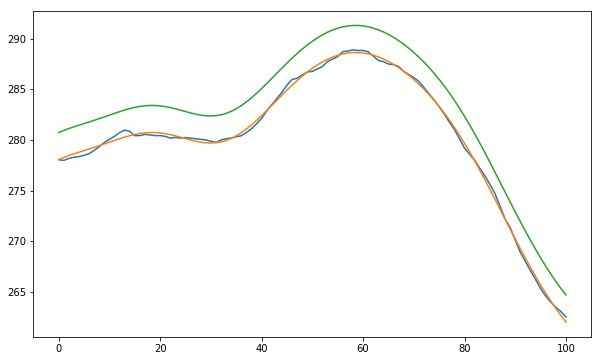

In [33]:
plt.figure(figsize=(10,6))    #グラフのサイズを10:6に設定
plt.plot(z[10000:10101])
plt.plot(zeta0[10000:10101])
plt.plot(zeta[10000:10101])
plt.show()

> 青曲線が`z`，オレンジ曲線が`zeta0`，緑曲線が`zeta`。オレンジ曲線および緑曲をみると，青曲線から綺麗にノイズが除去されているのがわかる。また緑曲線が他の曲線から上にずれているのは，バイアス（この場合負のバイアス＝要約統計量の`omega_z`の`mean`を見よ）が取り除かれているからである。

◼️平滑化された角速度のz成分$\zeta$(=`zeta`)を計測開始時刻0sから60s(60000ms)までプロットする：

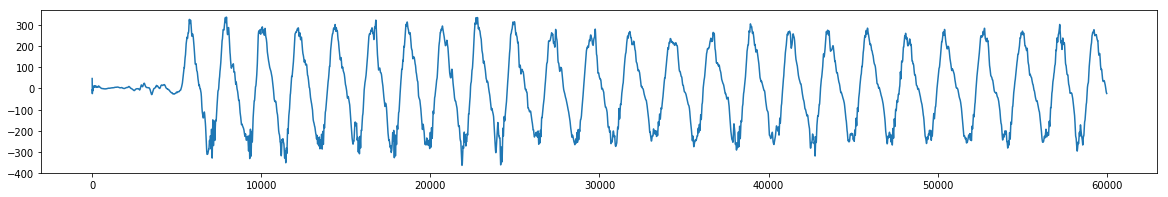

In [34]:
plt.figure(figsize=(20,3))    #グラフのサイズを20:3に設定
plt.plot(zeta[:60001])
plt.show()

> `zeta[:60001]`は`zeta[0:60001]`と同じ。`zeta`について，0ms〜60000msの60000個のデータ点をピックアップしている。

## ３．$\zeta$を積分することによって肩屈曲角度$\theta$を求める

◼️講義と次の図を参照して，$\zeta$(`zeta`)を積分し，肩屈曲角$\theta$(`theta`)を求めよ：    
<img src="fig001.png">

In [9]:
theta = integral(zeta, 0, 0, 60001)
#積分してθを求めるプログラムを自分で組め

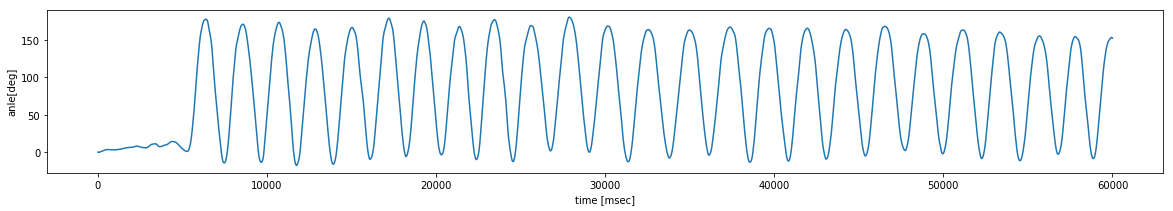

In [10]:
plt.figure(figsize=(20,3))
plt.plot(theta)
plt.xlabel('time [msec]')
plt.ylabel('anle[deg]')
plt.show()

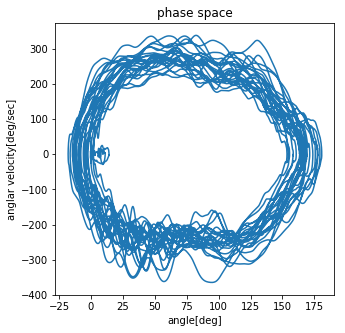

In [11]:
plt.figure(figsize=(5,5))
plt.plot(theta[0:60001], zeta[0:60001])
plt.title('phase space')
plt.xlabel('angle[deg]')
plt.ylabel('anglar velocity[deg/sec]')
plt.show()

In [12]:
import matplotlib.animation as anim
%matplotlib nbagg

<IPython.core.display.Javascript object>


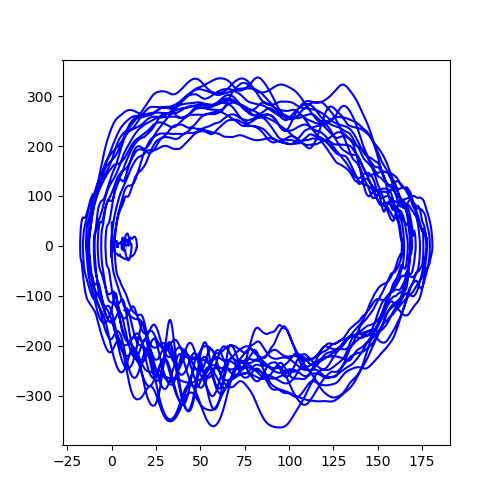

In [13]:
fig = plt.figure(figsize=(5,5))
ims = []
for i in range(0, 60000, 100):
    im = plt.plot(theta[0:i], zeta[0:i], c="blue")
    ims.append(im)
ani = anim.ArtistAnimation(fig, ims, interval=50)
plt.show()